# Classification_Airline Delay
#### 2024.7.2
#### Chulwon Chae

### Purpose of Data Analysis
    - Predict how much an aircraft will be delayed upon arrival.
    - Identify the reasons for delays and address these issues to improve service quality.

In [43]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from ydata_profiling import ProfileReport
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import kruskal
from scipy.stats import f_oneway

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

%matplotlib inline

## 1. Data Processing 1 

### 1-1 Data Load 

In [3]:
random_state = 1234

df_airlines = pd.read_csv("./data/4.Classification_Airline_delay/airlines.csv")
df_flights = pd.read_csv("./data/4.Classification_Airline_delay/flights.csv")
df_tzone_meta = pd.read_csv("./data/4.Classification_Airline_delay/tzone_meta.csv")
df_airports = pd.read_csv("./data/4.Classification_Airline_delay/airports.csv")
df_planes = pd.read_csv("./data/4.Classification_Airline_delay/planes.csv")
df_weather = pd.read_csv("./data/4.Classification_Airline_delay/weather.csv")

Check all the data

In [4]:
df_airlines.head()

,carrier,name
0,AA,American Airlines Inc.
1,AS,Alaska Airlines Inc.
2,B6,JetBlue Airways
3,DL,Delta Air Lines Inc.
4,EV,ExpressJet Airlines Inc.


In [5]:
df_flights.head()
# time needs to be change in proper manner

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,1537,N54711,EWR,MIA,148.0,1085.0,21.0,14.0,2017-10-01 21:00:00
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,1161,N37287,EWR,IAH,183.0,1400.0,5.0,25.0,2017-10-01 05:00:00
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,27,N547JB,EWR,MCO,133.0,937.0,5.0,45.0,2017-10-01 05:00:00
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,761,N38446,LGA,ORD,108.0,733.0,5.0,50.0,2017-10-01 05:00:00
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,521,N675NK,EWR,FLL,156.0,1065.0,6.0,0.0,2017-10-01 06:00:00


In [6]:
df_flights.info()
# some missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303748 entries, 0 to 303747
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            303748 non-null  int64  
 1   month           303748 non-null  int64  
 2   day             303748 non-null  int64  
 3   dep_time        295938 non-null  float64
 4   sched_dep_time  303748 non-null  int64  
 5   dep_delay       295934 non-null  float64
 6   arr_time        295600 non-null  float64
 7   sched_arr_time  303748 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         303748 non-null  object 
 10  flight          303748 non-null  int64  
 11  tailnum         302757 non-null  object 
 12  origin          303748 non-null  object 
 13  dest            303748 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        303748 non-null  float64
 16  hour            303748 non-null  float64
 17  minute    

In [7]:
df_flights.isna().sum()
# our target is predicting arr_deay, so will drop these NA

year                 0
month                0
day                  0
dep_time          7810
sched_dep_time       0
dep_delay         7814
arr_time          8148
sched_arr_time       0
arr_delay         8852
carrier              0
flight               0
tailnum            991
origin               0
dest                 0
air_time          8852
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

In [8]:
df_flights = df_flights.dropna(subset=['arr_delay']).copy()

In [9]:
df_tzone_meta.head()

,tzone,tzone_name
0,1,America/New_York
1,2,America/Chicago
2,3,America/Denver
3,4,America/Phoenix
4,5,America/Anchorage


In [10]:
df_airports.head()

,faa,name,lat,lon,alt,tz,dst,tzone
0,0V4,Brookneal/Campbell County Airport,37.141701,-79.016403,596,-5.0,A,1.0
1,19S,Sublette Municipal Airport,37.491402,-100.830002,2908,-5.0,A,NaN
2,23M,Clarke County Airport,32.084900,-88.738899,320,-6.0,A,2.0
3,2A5,Causey Airport,35.911800,-79.617599,723,-5.0,A,1.0
4,2H0,Shelby County Airport,39.410400,-88.845398,618,-6.0,A,2.0


In [11]:
df_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   faa     1333 non-null   object 
 1   name    1333 non-null   object 
 2   lat     1333 non-null   float64
 3   lon     1333 non-null   float64
 4   alt     1333 non-null   int64  
 5   tz      1277 non-null   float64
 6   dst     1277 non-null   object 
 7   tzone   1199 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 83.4+ KB


In [12]:
# check if df_flights and fd_airport can be join
# 'dest' 'origin
print(len(df_airports.faa.unique()))
df_airports.faa.unique()

1333


array(['0V4', '19S', '23M', ..., 'ZSY', 'ZUN', 'ZZV'], dtype=object)

In [13]:
np.intersect1d(df_flights.dest.unique(), df_airports.faa.unique())

array(['ABQ', 'ACK', 'ALB', 'ANC', 'ATL', 'AUS', 'AVL', 'AVP', 'BDL',
       'BGR', 'BHM', 'BNA', 'BOS', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN',
       'CAE', 'CAK', 'CHA', 'CHO', 'CHS', 'CLE', 'CLT', 'CMH', 'CVG',
       'DAB', 'DAL', 'DAY', 'DCA', 'DEN', 'DFW', 'DSM', 'DTW', 'EGE',
       'FLL', 'FNT', 'FWA', 'GRR', 'GSO', 'GSP', 'HDN', 'HNL', 'HOU',
       'HYA', 'IAD', 'IAH', 'ILM', 'IND', 'JAC', 'JAX', 'LAS', 'LAX',
       'LEX', 'LGB', 'MCI', 'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE',
       'MSN', 'MSP', 'MSY', 'MTJ', 'MVY', 'MYR', 'OAK', 'OMA', 'ORD',
       'ORF', 'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'PSP', 'PVD', 'PWM',
       'RDU', 'RIC', 'RNO', 'ROC', 'RSW', 'SAN', 'SAT', 'SAV', 'SBN',
       'SDF', 'SEA', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'SRQ', 'STL',
       'SYR', 'TPA', 'TUS', 'TVC', 'TYS', 'XNA'], dtype=object)

In [14]:
np.intersect1d(df_flights.origin.unique(), df_airports.faa.unique())

array(['EWR', 'JFK', 'LGA'], dtype=object)

In [15]:
df_planes.head()

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N102AA,2007.0,Fixed wing single engine,AVIAT AIRCRAFT INC,A-1B,1,2.0,NaN,Reciprocating
1,N103AA,2007.0,Fixed wing single engine,AVIAT AIRCRAFT INC,A-1B,1,2.0,NaN,Reciprocating
2,N103SY,2014.0,Fixed wing multi engine,EMBRAER S A,ERJ 170-200 LR,2,88.0,NaN,Turbo-fan
3,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55.0,NaN,Turbo-fan
4,N105AA,1978.0,Fixed wing single engine,CESSNA,R182,1,4.0,111.0,Reciprocating


In [16]:
df_planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tailnum       3521 non-null   object 
 1   year          3419 non-null   float64
 2   type          3521 non-null   object 
 3   manufacturer  3521 non-null   object 
 4   model         3521 non-null   object 
 5   engines       3521 non-null   int64  
 6   seats         3511 non-null   float64
 7   speed         62 non-null     float64
 8   engine        3521 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 247.7+ KB


In [17]:
df_planes.isna().sum()

tailnum            0
year             102
type               0
manufacturer       0
model              0
engines            0
seats             10
speed           3459
engine             0
dtype: int64

In [18]:
df_planes=df_planes.drop('speed',axis=1)

In [19]:
df_weather.head()


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2017.0,1.0,1,0,NaN,NaN,NaN,200.0,17.26170,19.864419,NaN,NaN,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,NaN,NaN,NaN,220.0,16.11092,18.540125,NaN,NaN,10.0,2017-01-01 09:00:00
2,EWR,2017.0,1.0,1,2,NaN,NaN,NaN,190.0,11.50780,13.242946,NaN,NaN,10.0,2017-01-01 10:00:00
3,EWR,2017.0,1.0,1,3,NaN,NaN,NaN,190.0,8.05546,9.270062,NaN,NaN,10.0,2017-01-01 11:00:00
4,EWR,2017.0,1.0,1,4,NaN,NaN,NaN,220.0,9.20624,10.594357,NaN,NaN,10.0,2017-01-01 12:00:00


In [20]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26201 entries, 0 to 26200
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   temp        559 non-null    float64
 6   dewp        559 non-null    float64
 7   humid       559 non-null    float64
 8   wind_dir    23540 non-null  float64
 9   wind_speed  23554 non-null  float64
 10  wind_gust   23554 non-null  float64
 11  precip      1370 non-null   float64
 12  pressure    433 non-null    float64
 13  visib       26190 non-null  float64
 14  time_hour   26201 non-null  object 
dtypes: float64(11), int64(2), object(2)
memory usage: 3.0+ MB


In [21]:
df_weather.isna().sum()

origin            0
year              0
month             0
day               0
hour              0
temp          25642
dewp          25642
humid         25642
wind_dir       2661
wind_speed     2647
wind_gust      2647
precip        24831
pressure      25768
visib            11
time_hour         0
dtype: int64

In [22]:
df_weather = df_weather.drop(["temp", "dewp", "humid","precip","pressure"], axis=1)
df_weather

,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour
0,EWR,2017.0,1.0,1,0,200.0,17.26170,19.864419,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,220.0,16.11092,18.540125,10.0,2017-01-01 09:00:00
2,EWR,2017.0,1.0,1,2,190.0,11.50780,13.242946,10.0,2017-01-01 10:00:00
3,EWR,2017.0,1.0,1,3,190.0,8.05546,9.270062,10.0,2017-01-01 11:00:00
4,EWR,2017.0,1.0,1,4,220.0,9.20624,10.594357,10.0,2017-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...
26196,LGA,2017.0,12.0,30,19,210.0,9.20624,10.594357,5.0,2017-12-31 03:00:00
26197,LGA,2017.0,12.0,30,20,200.0,10.35702,11.918651,10.0,2017-12-31 04:00:00
26198,LGA,2017.0,12.0,30,21,280.0,8.05546,9.270062,10.0,2017-12-31 05:00:00
26199,LGA,2017.0,12.0,30,22,260.0,10.35702,11.918651,10.0,2017-12-31 06:00:00


Since wheather would be affected by weather from yesterday, i will use ffill.

In [23]:
df_weather = df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill"))

/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_43654/4238929852.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather = df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill"))
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_43654/4238929852.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weather = df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill"))


In [24]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26201 entries, ('EWR', 0) to ('LGA', 26200)
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   wind_dir    26200 non-null  float64
 6   wind_speed  26200 non-null  float64
 7   wind_gust   26200 non-null  float64
 8   visib       26201 non-null  float64
 9   time_hour   26201 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 3.3+ MB


In [25]:
df_weather[8730:8740]

origin    year  month  day  hour  wind_dir  wind_speed  wind_gust  \
origin                                                                          
EWR    8730    EWR  2017.0   12.0   30    19     230.0     4.60312   5.297178   
       8731    EWR  2017.0   12.0   30    20     220.0     8.05546   9.270062   
       8732    EWR  2017.0   12.0   30    21     280.0    10.35702  11.918651   
       8733    EWR  2017.0   12.0   30    22     260.0     6.90468   7.945768   
       8734    EWR  2017.0   12.0   30    23     280.0     6.90468   7.945768   
JFK    8735    JFK  2017.0    1.0    1     0       NaN         NaN        NaN   
       8736    JFK  2017.0    1.0    1     1     220.0    14.96014  17.215830   
       8737    JFK  2017.0    1.0    1     2     200.0    14.96014  17.215830   
       8738    JFK  2017.0    1.0    1     3     220.0    13.80936  15.891535   
       8739    JFK  2017.0    1.0    1     4     220.0    12.65858  14.567241   

             visib            time_hour  
origin                                   
EWR    8730    4.0  2017-12-31 03:00:00  
       8731    9.0  2017-12-31 04:00:00  
       8732   10.0  2017-12-31 05:00:00  
       8733   10.0  2017-12-31 06:00:00  
       8734   10.0  2017-12-31 07:00:00  
JFK    8735   10.0  2017-01-01 08:00:00  
       8736   10.0  2017-01-01 09:00:00  
       8737   10.0  2017-01-01 10:00:00  
       8738   10.0  2017-01-01 11:00:00  
       8739   10.0  2017-01-01 12:00:00

In [26]:
df_weather[df_weather['wind_dir'].isnull()]

,,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour
origin,,,,,,,,,,,
JFK,8735,JFK,2017.0,1.0,1,0,NaN,NaN,NaN,10.0,2017-01-01 08:00:00


In [27]:
df_weather = df_weather.apply(lambda x: x.bfill()).reset_index(drop=True)


In [28]:
df_weather[df_weather['wind_dir'].isnull()]

,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour


In [29]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26201 entries, 0 to 26200
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   wind_dir    26201 non-null  float64
 6   wind_speed  26201 non-null  float64
 7   wind_gust   26201 non-null  float64
 8   visib       26201 non-null  float64
 9   time_hour   26201 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 2.0+ MB


### 1-3 Data Join
#### Join Process

#### 1. Join df_flights with df_airports: Join using df_flights["dest"] and df_airports["faa"]. Although it's possible to join using df_flights["origin"] and df_airports["faa"], the number of airports for origin is limited, so the join is performed on dest only.
    Combine flight information with detailed airport information.

#### 2. Join the result of step 1 with df_planes: Join using step1_df["tailnum"] and df_planes["tailnum"].
    Combine flight information with detailed plane information.

#### 3. Join the result of step 2 with df_weather: Join using step2_df[["origin", "time_hour"]] and df_weather[["origin", "time_hour"]].
    Combine flight information with weather information for the departure and arrival locations.

In [30]:
df_flight_and_airport = pd.merge(df_flights, df_airports, how='left', left_on='dest',right_on='faa')
df_flight_and_airport.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,minute,time_hour,faa,name,lat,lon,alt,tz,dst,tzone
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,14.0,2017-10-01 21:00:00,MIA,Miami International Airport,25.793200,-80.290604,8.0,-5.0,A,1.0
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,25.0,2017-10-01 05:00:00,IAH,George Bush Intercontinental Houston Airport,29.984400,-95.341400,97.0,-6.0,A,2.0
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,45.0,2017-10-01 05:00:00,MCO,Orlando International Airport,28.429399,-81.308998,96.0,-5.0,A,1.0
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,50.0,2017-10-01 05:00:00,ORD,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,-6.0,A,2.0
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,0.0,2017-10-01 06:00:00,FLL,Fort Lauderdale Hollywood International Airport,26.072599,-80.152702,9.0,-5.0,A,1.0


In [31]:
df_f_a_p = pd.merge(df_flight_and_airport, df_planes, how='left', on='tailnum', suffixes=("_flights","_planes"))
df_f_a_p.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,tz,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,-5.0,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,-6.0,A,2.0,2004.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,-5.0,A,1.0,2002.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,-6.0,A,2.0,2012.0,Fixed wing multi engine,BOEING,737-924ER,2.0,191.0,Turbo-fan
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,-5.0,A,1.0,2017.0,Fixed wing multi engine,AIRBUS,A321-231,2.0,379.0,Turbo-fan


In [32]:
# Join the result of step 2 with df_weather
# Two types of joins are possible:
# 1) Weather information at the departure time
# 2) Weather information at the arrival time: It's unclear how to obtain this with the given data, so it is not performed. However, if possible, it would be good to include.

# 3 Weather information at the departure time
df_f_a_p["dest_datetime"] = pd.to_datetime(df_f_a_p["time_hour"])
# Since time_hour reflects the scheduled departure time, the actual delayed departure time needs to be added to this data.
# Additionally, time_hour does not include 'minutes', so the minutes column data needs to be added as well.
df_f_a_p["dest_datetime"] = df_f_a_p.apply(lambda x: x.dest_datetime + pd.Timedelta(minutes=x.dep_delay) + pd.Timedelta(minutes=x.minute), axis=1)


In [33]:
df_f_a_p["time_hour"]

0         2017-10-01 21:00:00
1         2017-10-01 05:00:00
2         2017-10-01 05:00:00
3         2017-10-01 05:00:00
4         2017-10-01 06:00:00
                 ...         
294891    2017-09-30 22:00:00
294892    2017-09-30 22:00:00
294893    2017-09-30 22:00:00
294894    2017-09-30 23:00:00
294895    2017-09-30 22:00:00
Name: time_hour, Length: 294896, dtype: object

In [34]:
df_f_a_p["dest_datetime"]

0        2017-10-02 00:27:00
1        2017-10-01 05:19:00
2        2017-10-01 05:44:00
3        2017-10-01 05:46:00
4        2017-10-01 05:52:00
                 ...        
294891   2017-09-30 22:38:00
294892   2017-09-30 22:41:00
294893   2017-09-30 22:48:00
294894   2017-09-30 23:19:00
294895   2017-09-30 23:25:00
Name: dest_datetime, Length: 294896, dtype: datetime64[ns]

In [35]:
df_f_a_p.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine,dest_datetime
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:27:00
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,A,2.0,2004.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan,2017-10-01 05:19:00
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,A,1.0,2002.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,2017-10-01 05:44:00
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,A,2.0,2012.0,Fixed wing multi engine,BOEING,737-924ER,2.0,191.0,Turbo-fan,2017-10-01 05:46:00
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,A,1.0,2017.0,Fixed wing multi engine,AIRBUS,A321-231,2.0,379.0,Turbo-fan,2017-10-01 05:52:00


In [36]:
df_weather.head()

,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour
0,EWR,2017.0,1.0,1,0,200.0,17.26170,19.864419,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,220.0,16.11092,18.540125,10.0,2017-01-01 09:00:00
2,EWR,2017.0,1.0,1,2,190.0,11.50780,13.242946,10.0,2017-01-01 10:00:00
3,EWR,2017.0,1.0,1,3,190.0,8.05546,9.270062,10.0,2017-01-01 11:00:00
4,EWR,2017.0,1.0,1,4,220.0,9.20624,10.594357,10.0,2017-01-01 12:00:00


In [37]:
# Remove minute information from dest_datetime to join with weather data
df_f_a_p["dest_datetime"] = df_f_a_p["dest_datetime"].dt.strftime("%Y-%m-%d %H:00:00")

# Display the first row to verify the changes
df_f_a_p.head()


,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine,dest_datetime
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:00:00
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,A,2.0,2004.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan,2017-10-01 05:00:00
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,A,1.0,2002.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,2017-10-01 05:00:00
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,A,2.0,2012.0,Fixed wing multi engine,BOEING,737-924ER,2.0,191.0,Turbo-fan,2017-10-01 05:00:00
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,A,1.0,2017.0,Fixed wing multi engine,AIRBUS,A321-231,2.0,379.0,Turbo-fan,2017-10-01 05:00:00


In [38]:
df_f_a_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294896 entries, 0 to 294895
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year_flights    294896 non-null  int64  
 1   month           294896 non-null  int64  
 2   day             294896 non-null  int64  
 3   dep_time        294896 non-null  float64
 4   sched_dep_time  294896 non-null  int64  
 5   dep_delay       294896 non-null  float64
 6   arr_time        294896 non-null  float64
 7   sched_arr_time  294896 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         294896 non-null  object 
 10  flight          294896 non-null  int64  
 11  tailnum         294896 non-null  object 
 12  origin          294896 non-null  object 
 13  dest            294896 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        294896 non-null  float64
 16  hour            294896 non-null  float64
 17  minute    

In [39]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26201 entries, 0 to 26200
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   wind_dir    26201 non-null  float64
 6   wind_speed  26201 non-null  float64
 7   wind_gust   26201 non-null  float64
 8   visib       26201 non-null  float64
 9   time_hour   26201 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 2.0+ MB


In [40]:
# To join, df_weather['time_hour'] should chnage into 'dest_datetime'
df_weather = df_weather.rename(columns={'time_hour': 'dest_datetime' })

In [41]:
df_final = pd.merge(df_f_a_p, df_weather, how="left", on=["origin","dest_datetime"], suffixes=("", "_weather"))
# _x, _y

In [42]:
df_final.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,dest_datetime,year,month_weather,day_weather,hour_weather,wind_dir,wind_speed,wind_gust,visib
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,Turbo-fan,2017-10-02 00:00:00,2017.0,10.0,1.0,17.0,40.0,9.20624,10.594357,10.0
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,19.56326,22.513008,10.0
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0


### 1-4 Duplicated Data

In [43]:
print("Number of Duplicated :", len(df_final[df_final.duplicated()])) 

Number of Duplicated : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294896 entries, 0 to 294895
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year_flights    294896 non-null  int64  
 1   month           294896 non-null  int64  
 2   day             294896 non-null  int64  
 3   dep_time        294896 non-null  float64
 4   sched_dep_time  294896 non-null  int64  
 5   dep_delay       294896 non-null  float64
 6   arr_time        294896 non-null  float64
 7   sched_arr_time  294896 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         294896 non-null  object 
 10  flight          294896 non-null  int64  
 11  tailnum         294896 non-null  object 
 12  origin          294896 non-null  object 
 13  dest            294896 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        294896 non-null  float64
 16  hour            294896 non-null  float64
 17  minute    

In [45]:
df_final.isna().sum()

year_flights          0
month                 0
day                   0
dep_time              0
sched_dep_time        0
dep_delay             0
arr_time              0
sched_arr_time        0
arr_delay             0
carrier               0
flight                0
tailnum               0
origin                0
dest                  0
air_time              0
distance              0
hour                  0
minute                0
time_hour             0
faa                5982
name               5982
lat                5982
lon                5982
alt                5982
tz                 5982
dst                5982
tzone              5982
year_planes       43853
type              36313
manufacturer      36313
model             36313
engines           36313
seats             36930
engine            36313
dest_datetime         0
year                783
month_weather       783
day_weather         783
hour_weather        783
wind_dir            783
wind_speed          783
wind_gust       

In [46]:
# categorical and numerical
for column_name in list(df_final.columns):
    print(column_name, type(df_final[column_name][0]), df_final[column_name].unique())

year_flights <class 'numpy.int64'> [2017]
month <class 'numpy.int64'> [10 11 12  1  2  3  4  5  6  7  8  9]
day <class 'numpy.int64'> [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
dep_time <class 'numpy.float64'> [ 27. 519. 544. ... 254. 425. 400.]
sched_dep_time <class 'numpy.int64'> [2114  525  545 ... 2231 2111 2354]
dep_delay <class 'numpy.float64'> [ 1.930e+02 -6.000e+00 -1.000e+00 -4.000e+00 -8.000e+00 -7.000e+00
 -1.200e+01 -5.000e+00 -3.000e+00 -9.000e+00  7.330e+02  0.000e+00
  3.300e+01  1.000e+00 -1.100e+01 -1.000e+01 -2.000e+00  1.200e+01
 -1.400e+01  5.000e+00  3.000e+00  2.000e+00  1.500e+01  1.400e+01
  3.400e+01  5.200e+01  1.530e+02 -1.700e+01 -1.600e+01  7.000e+00
 -1.300e+01  2.200e+01  8.000e+00  6.100e+01 -2.100e+01  7.600e+01
  2.800e+01  4.000e+00  9.000e+00  1.020e+02  1.080e+02 -1.500e+01
  1.800e+01  5.000e+01  1.900e+01  6.000e+00  4.900e+01  2.000e+01
  1.000e+01  3.000e+01  2.300e+01  5.600e+01  1.600e+01  6

In [47]:
df_final.select_dtypes(include=['int64']).columns

Index(['year_flights', 'month', 'day', 'sched_dep_time', 'sched_arr_time',
       'flight'],
      dtype='object')

In [48]:
# If float type columns do not exhibit numeric characteristics, they are heuristically judged and classified.
df_final.select_dtypes(include=['float64']).columns

# dep_time and arr_time represent times, and since the hour and minute data are in datetime format (%H%M), conversion is needed.
# wind_dir is also considered categorical (because it represents an angle).


Index(['dep_time', 'dep_delay', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'hour', 'minute', 'lat', 'lon', 'alt', 'tz', 'tzone',
       'year_planes', 'engines', 'seats', 'year', 'month_weather',
       'day_weather', 'hour_weather', 'wind_dir', 'wind_speed', 'wind_gust',
       'visib'],
      dtype='object')

In [49]:
df_final["dep_time"] = df_final["dep_time"].apply(lambda x: '{0:04d}'.format(int(x)))
df_final["arr_time"] = df_final["arr_time"].apply(lambda x: '{0:04d}'.format(int(x)))
df_final["wind_dir"] = df_final["wind_dir"].astype("str")

In [50]:
list_categorical_columns = list(df_final.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_final.select_dtypes(include=['float64']).columns)
target_column = "arr_delay"

In [51]:
print(len(df_final.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

43
22
21


In [52]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294896 entries, 0 to 294895
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year_flights    294896 non-null  int64  
 1   month           294896 non-null  int64  
 2   day             294896 non-null  int64  
 3   dep_time        294896 non-null  object 
 4   sched_dep_time  294896 non-null  int64  
 5   dep_delay       294896 non-null  float64
 6   arr_time        294896 non-null  object 
 7   sched_arr_time  294896 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         294896 non-null  object 
 10  flight          294896 non-null  int64  
 11  tailnum         294896 non-null  object 
 12  origin          294896 non-null  object 
 13  dest            294896 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        294896 non-null  float64
 16  hour            294896 non-null  float64
 17  minute    

#### Summary of Data
#### Number of variables : 43
    numeric variables : 21(target column)
    categorical varabiels : 22 
#### Number of observations : 294896
#### Duplicated Cells : 0


### 2-2 Dependent Data Explore

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='arr_delay', ylabel='Count'>

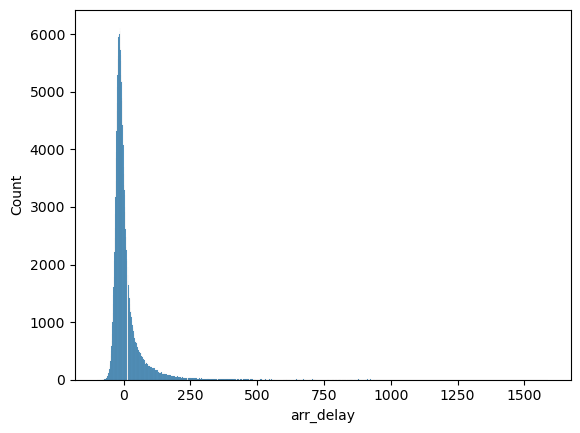

In [53]:
sns.histplot(data=df_final, x='arr_delay')

In [54]:
print(stats.skew(df_final['arr_delay']))
print(stats.kurtosis(df_final['arr_delay']))

5.559168844552731
64.17521265711945


<Axes: xlabel='arr_delay'>

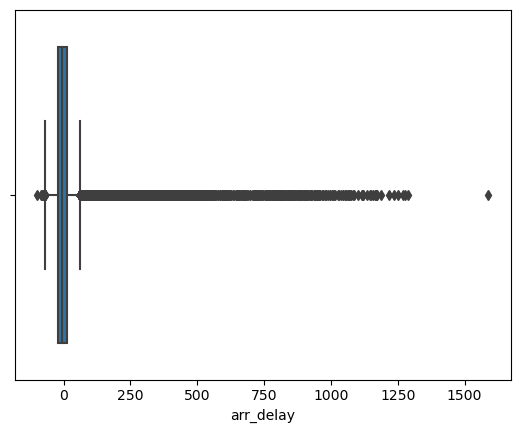

In [55]:
sns.boxplot(data=df_final, x='arr_delay')

<Axes: xlabel='arr_delay'>

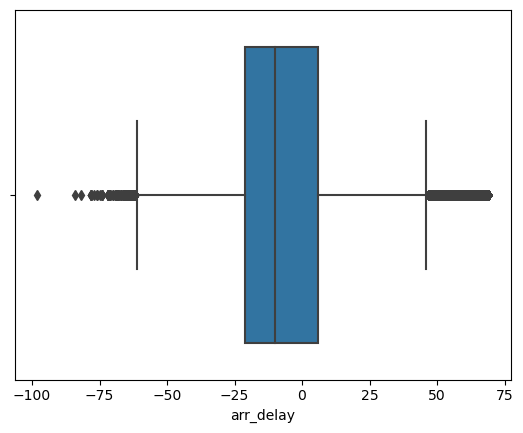

In [56]:
sns.boxplot(data=df_final[df_final.arr_delay < 70], x='arr_delay')

In [57]:
df_final["arr_delay"].describe()

count    294896.000000
mean          7.104023
std          55.323259
min         -98.000000
25%         -20.000000
50%          -7.000000
75%          13.000000
max        1589.000000
Name: arr_delay, dtype: float64

### 2-3 Independent Data Explore

In [58]:
df_final.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,dest_datetime,year,month_weather,day_weather,hour_weather,wind_dir,wind_speed,wind_gust,visib
0,2017,10,1,0027,2114,193.0,0317,15,182.0,UA,...,Turbo-fan,2017-10-02 00:00:00,2017.0,10.0,1.0,17.0,40.0,9.20624,10.594357,10.0
1,2017,10,1,0519,525,-6.0,0741,759,-18.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
2,2017,10,1,0544,545,-1.0,0815,819,-4.0,B6,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
3,2017,10,1,0546,550,-4.0,0702,719,-17.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,19.56326,22.513008,10.0
4,2017,10,1,0552,600,-8.0,0846,850,-4.0,NK,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0


In [61]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
year_flights,294896.0,2017.000000,0.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
month,294896.0,6.556732,3.414072,1.000000,4.000000,7.000000,10.000000,12.000000
day,294896.0,15.821788,8.793233,1.000000,8.000000,16.000000,23.000000,31.000000
sched_dep_time,294896.0,1343.360388,477.824403,111.000000,905.000000,1345.000000,1740.000000,2359.000000
dep_delay,294896.0,15.083009,51.793249,-84.000000,-6.000000,-2.000000,11.000000,1548.000000
sched_arr_time,294896.0,1521.107706,530.841880,1.000000,1118.000000,1536.000000,1950.000000,2359.000000
arr_delay,294896.0,7.104023,55.323259,-98.000000,-20.000000,-7.000000,13.000000,1589.000000
flight,294896.0,1687.296603,1452.006474,1.000000,518.000000,1332.000000,2227.000000,6988.000000
air_time,294896.0,164.489427,97.872896,20.000000,99.000000,139.000000,211.000000,712.000000
distance,294896.0,1160.316461,762.675907,93.000000,636.000000,1005.000000,1598.000000,4983.000000


#### Drop irrelevant columns

In [62]:
df_final.apply(lambda x: x.unique())

year_flights                                                 [2017]
month                       [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
day               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
dep_time          [0027, 0519, 0544, 0546, 0552, 0553, 0554, 055...
sched_dep_time    [2114, 525, 545, 550, 600, 607, 606, 610, 615,...
dep_delay         [193.0, -6.0, -1.0, -4.0, -8.0, -7.0, -12.0, -...
arr_time          [0317, 0741, 0815, 0702, 0846, 0852, 0844, 083...
sched_arr_time    [15, 759, 819, 719, 850, 858, 844, 853, 902, 8...
arr_delay         [182.0, -18.0, -4.0, -17.0, -6.0, 0.0, -22.0, ...
carrier            [UA, B6, NK, AA, DL, WN, EV, AS, OO, VX, F9, HA]
flight            [1537, 1161, 27, 761, 521, 23, 129, 1465, 1301...
tailnum           [N54711, N37287, N547JB, N38446, N675NK, N967J...
origin                                              [EWR, LGA, JFK]
dest              [MIA, IAH, MCO, ORD, FLL, LAX, DFW, ATL, MDW, ...
air_time          [148.0, 183.0, 133.0, 108.0, 1

In [63]:
df_final = df_final.drop(['year_flights', 'sched_dep_time', 'arr_time', 'sched_arr_time','hour', 'minute', 'time_hour','tz', 'dst', 'tzone', 'year', 'month_weather', 'day_weather', 'hour_weather'],axis=1).copy()
df_final.head(3)

,month,day,dep_time,dep_delay,arr_delay,carrier,flight,tailnum,origin,dest,...,manufacturer,model,engines,seats,engine,dest_datetime,wind_dir,wind_speed,wind_gust,visib
0,10,1,0027,193.0,182.0,UA,1537,N54711,EWR,MIA,...,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:00:00,40.0,9.20624,10.594357,10.0
1,10,1,0519,-6.0,-18.0,UA,1161,N37287,EWR,IAH,...,BOEING,737-824,2.0,149.0,Turbo-fan,2017-10-01 05:00:00,360.0,16.11092,18.540125,10.0
2,10,1,0544,-1.0,-4.0,B6,27,N547JB,EWR,MCO,...,AIRBUS,A320-232,2.0,200.0,Turbo-fan,2017-10-01 05:00:00,360.0,16.11092,18.540125,10.0


In [64]:
list_categorical_columns = list(df_final.select_dtypes(include=['int64','object']).columns)
list_numeric_columns = list(df_final.select_dtypes(include=['float64']).columns)
print(len(df_final.columns))
print("categorical columns : ",len(list_categorical_columns))
print("numerical columns : ", len(list_numeric_columns))

29
categorical columns :  16
numerical columns :  13


#### 1) categorical column EDA

In [65]:
list_categorical_columns

['month',
 'day',
 'dep_time',
 'carrier',
 'flight',
 'tailnum',
 'origin',
 'dest',
 'faa',
 'name',
 'type',
 'manufacturer',
 'model',
 'engine',
 'dest_datetime',
 'wind_dir']

<Axes: xlabel='arr_delay', ylabel='origin'>

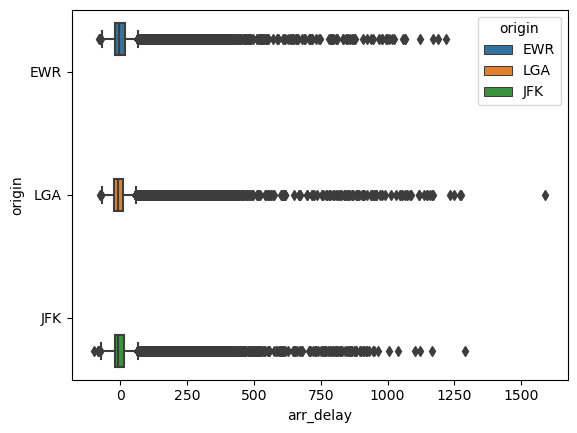

In [67]:
# 1) Check whether there is a correlation between 'arr_delay' and 'origin'.
sns.boxplot(data=df_final, x='arr_delay', y='origin', hue='origin')

<Axes: xlabel='arr_delay', ylabel='origin'>

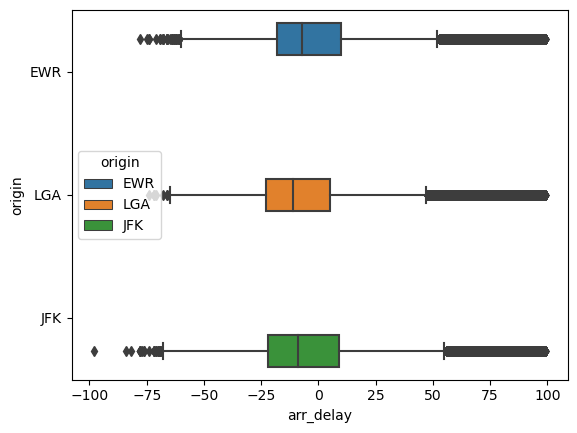

In [68]:
sns.boxplot(data=df_final[df_final.arr_delay<100], x='arr_delay', y='origin', hue='origin')

<Axes: xlabel='arr_delay', ylabel='engine'>

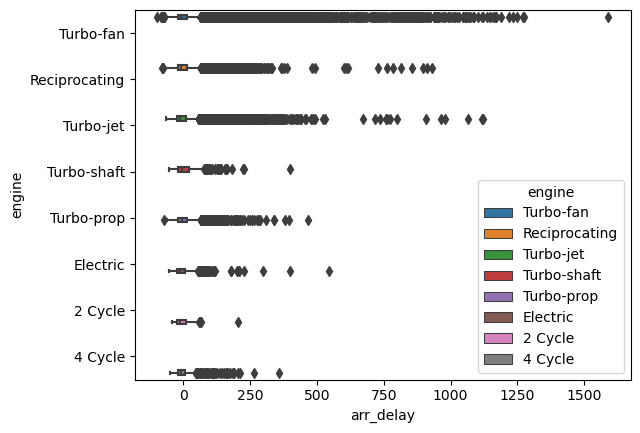

In [69]:
# Could there be a difference in arr_delay based on the type of airplane engine?
sns.boxplot(data=df_final, x='arr_delay', y='engine', hue='engine')

# Insight
# The data distribution shows the 'arr_delay' tend to be longer for Turbo-fan engines.
# For 2 Cycle engines, the 'arr_delay' is relatively shorter.

<Axes: xlabel='distance', ylabel='engine'>

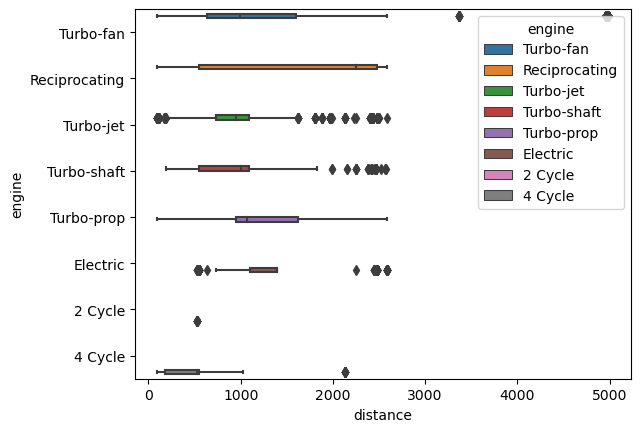

In [70]:
# Above, there appears to be a difference in arr_delay based on the engine type. 
# Could this be because certain engines are used more frequently for longer distances? (Assumption and Exploration)
sns.boxplot(data=df_final,x='distance',y='engine',hue='engine')
#Reciprocating engines seem to be used more often for longer distances, 
# but they tend to have shorter arr_delay compared to Turbo-fan engines (relatively speaking).

<Axes: xlabel='month', ylabel='arr_delay'>

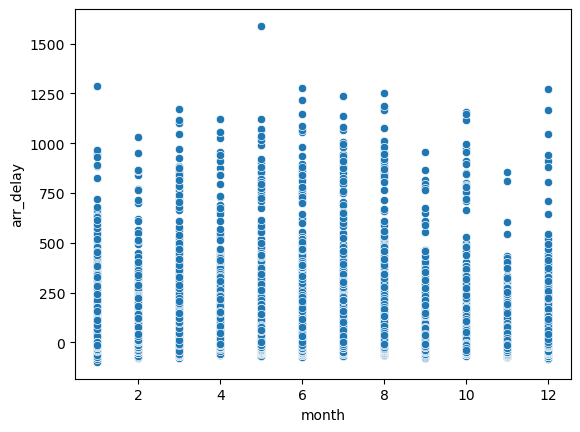

In [71]:
# When the number of distinct values in a categorical column is too high, a scatter plot can be used to check the overall distribution and interaction.

# 1) Exploration Based on the Month of Operation
sns.scatterplot(data=df_final, x="month", y="arr_delay")

<Axes: xlabel='carrier', ylabel='arr_delay'>

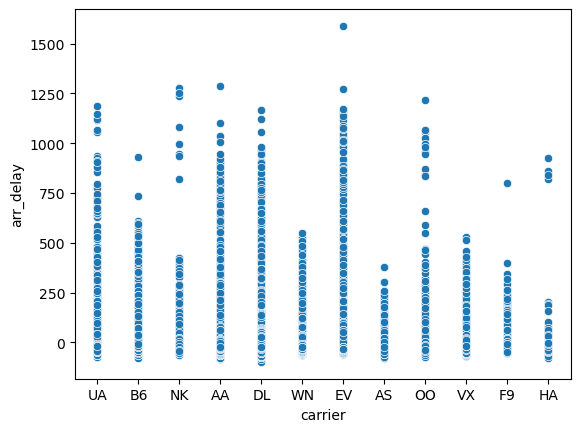

In [73]:
# arr_delay based on the carrier
sns.scatterplot(data=df_final, x='carrier',y='arr_delay')

<Axes: xlabel='arr_delay', ylabel='carrier'>

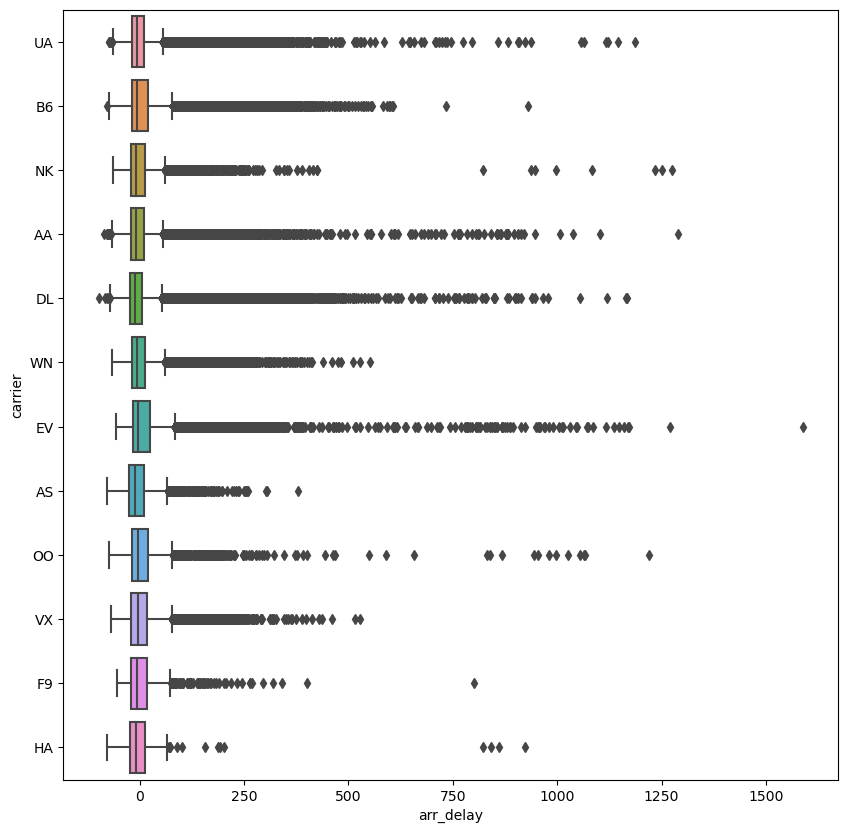

In [74]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_final, x='arr_delay', y='carrier')

<Axes: xlabel='arr_delay', ylabel='carrier'>

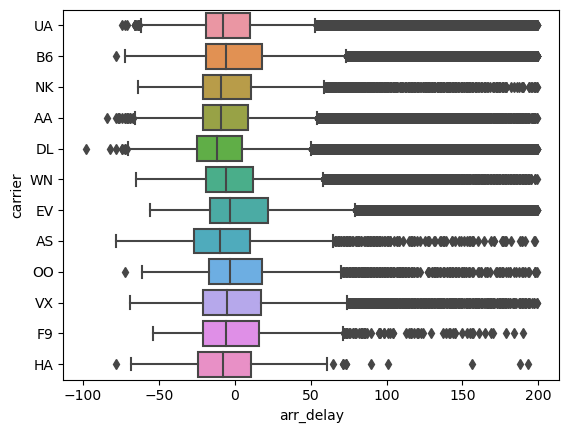

In [76]:
sns.boxplot(data=df_final[df_final.arr_delay < 200], x="arr_delay", y="carrier")

#### Testing Categorical and Numerical Data
- There are parametric and non-parametric methods to test the association between categorical and numerical data.
- Parametric Method: ANOVA
- Non-parametric Method: Kruskal-Wallis
- The parametric method can be challenging to apply as it requires meeting various conditions, but it tends to be more accurate than the non-parametric method.

#### One-Way Analysis of Variance (ANOVA)
- Used to test differences in the distribution of numeric data across categories.
For example, testing the height distribution across different genders.
- Assumptions: Normality, homogeneity of variances, and independence (the test cannot be trusted if these are not satisfied).
- We will test the relationship between categorical data and arr_delay distribution.
- If the p-value is less than or equal to 0.05, we reject the null hypothesis (though the p-value threshold can vary, 0.05 is commonly used).

#### Normality Test
- For variance analysis, the data must satisfy normality.
- Various methods can be used to test normality: QQ plot, Shapiro-Wilk test.

((array([-4.57770925, -4.38855194, -4.2859886 , ...,  4.2859886 ,
          4.38855194,  4.57770925]),
  array([ -98.,  -84.,  -82., ..., 1276., 1289., 1589.])),
 (43.31356057220851, 7.104023113233141, 0.782906408644274))

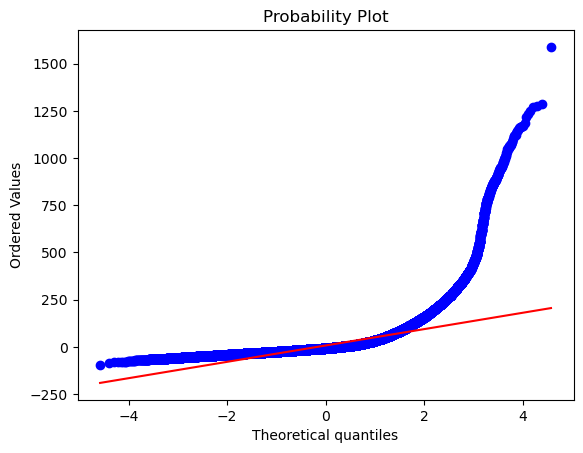

In [77]:
stats.probplot(df_final[target_column], dist=stats.norm, plot=plt)

#### Normality Not Satisfied
- If normality is not satisfied, there is no need to test for homogeneity of variances (as it assumes normality).
- Numeric data testing through one-way ANOVA is not feasible.

#### Kruskal-Wallis Test (Non-parametric Test)
- As a non-parametric test, it does not require normality or homogeneity of variances.
- However, being a non-parametric test, the reliability of the results is lower compared to parametric tests.

In [78]:
df_final[list_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294896 entries, 0 to 294895
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   month          294896 non-null  int64 
 1   day            294896 non-null  int64 
 2   dep_time       294896 non-null  object
 3   carrier        294896 non-null  object
 4   flight         294896 non-null  int64 
 5   tailnum        294896 non-null  object
 6   origin         294896 non-null  object
 7   dest           294896 non-null  object
 8   faa            288914 non-null  object
 9   name           288914 non-null  object
 10  type           258583 non-null  object
 11  manufacturer   258583 non-null  object
 12  model          258583 non-null  object
 13  engine         258583 non-null  object
 14  dest_datetime  294896 non-null  object
 15  wind_dir       294896 non-null  object
dtypes: int64(3), object(13)
memory usage: 36.0+ MB


In [79]:
# kruskall 검정 (시간 많이 소요됨)
list_meaningful_column_by_kruskall = []

for column_name in list_categorical_columns:
  list_by_value = []
  for value in df_final[column_name].dropna().unique():
      df_tmp = df_final[df_final[column_name] == value][target_column].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

month ,  4517.169007971446 ,  0.0
day ,  2011.547273385221 ,  0.0
dep_time ,  37326.48957806564 ,  0.0
carrier ,  4749.565614373608 ,  0.0
flight ,  29017.821278409894 ,  0.0
tailnum ,  11539.928221649188 ,  0.0
origin ,  2058.537468530962 ,  0.0
dest ,  4846.796839777051 ,  0.0
faa ,  4662.731186640077 ,  0.0
name ,  4662.731186640077 ,  0.0
type ,  13.178586013957197 ,  0.004265896440157533
manufacturer ,  2791.479839545662 ,  0.0
model ,  6264.888258101361 ,  0.0
engine ,  252.9007963705475 ,  6.685238031099385e-51
dest_datetime ,  87157.90797333283 ,  0.0
wind_dir ,  1798.8922942734612 ,  0.0
all categorical columns :  16
selected columns by kruskal :  16 ['month', 'day', 'dep_time', 'carrier', 'flight', 'tailnum', 'origin', 'dest', 'faa', 'name', 'type', 'manufacturer', 'model', 'engine', 'dest_datetime', 'wind_dir']


#### Insight
- The Kruskal-Wallis test indicates that all categorical data have a significant relationship with the dependent variable.

#### 2) numeric(continous) column EDA

<Axes: >

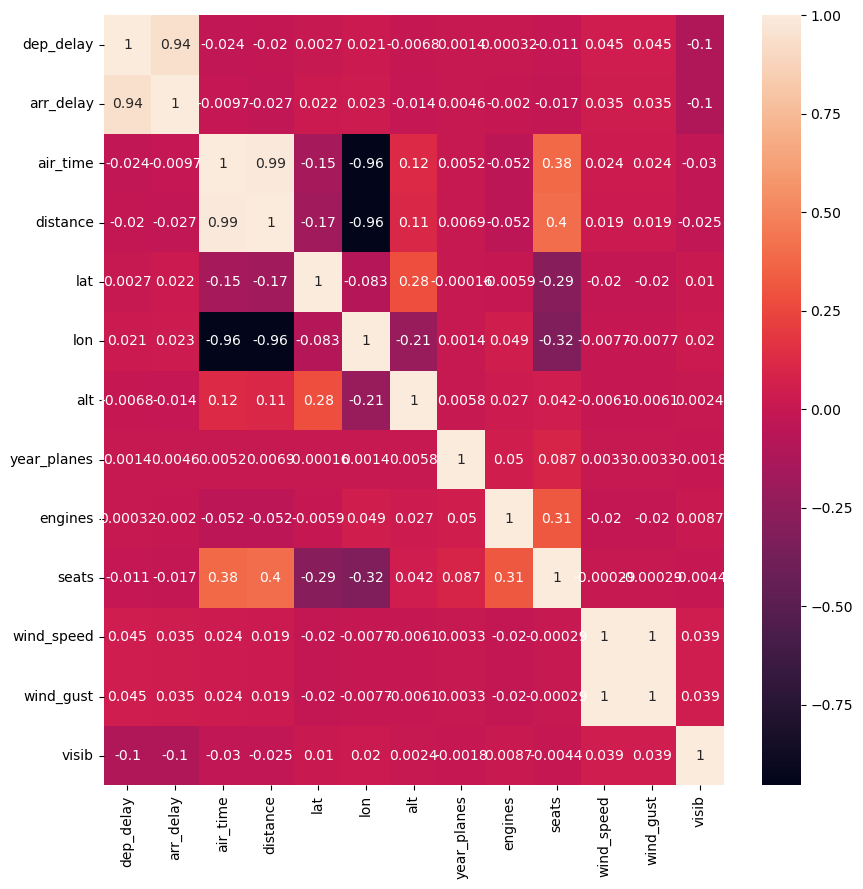

In [83]:
df_corr = df_final.loc[:,list_numeric_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)

#### Removing Data with High Correlation

- Remove data with a correlation value that is too high.
- Ensure that the correlation values are reliable before making any decisions.
- The threshold for removal is an absolute value of 0.9 or higher.

In [84]:
index_corr_over_90 = np.where((abs(df_corr)>0.9)&(df_corr !=1))
index_corr_over_90

(array([ 0,  1,  2,  2,  3,  3,  5,  5, 10, 11]),
 array([ 1,  0,  3,  5,  2,  5,  2,  3, 11, 10]))

In [85]:
len_corr_over_90 = len(index_corr_over_90[0])
left_columns = df_corr.columns[index_corr_over_90[0]]
right_columns = df_corr.columns[index_corr_over_90[1]]
for index in range(len_corr_over_90):
  print(left_columns[index], "<->", right_columns[index])  
  

dep_delay <-> arr_delay
arr_delay <-> dep_delay
air_time <-> distance
air_time <-> lon
distance <-> air_time
distance <-> lon
lon <-> air_time
lon <-> distance
wind_speed <-> wind_gust
wind_gust <-> wind_speed


In [86]:
list_not_valid = []
df_final_corr = df_final.dropna()
for index in range(len_corr_over_90):
    statistic, pvalue = stats.pearsonr(df_final_corr.loc[:,left_columns[index]], df_final_corr.loc[:,right_columns[index]])
    print("%s<->%s : %f %f"%(left_columns[index],right_columns[index] , statistic, pvalue))
    if (pvalue > 0.05):
        list_not_valid.append(column_name)
print("end")
print(len(list_not_valid), " is not valids")

dep_delay<->arr_delay : 0.943188 0.000000
arr_delay<->dep_delay : 0.943188 0.000000
air_time<->distance : 0.992410 0.000000
air_time<->lon : -0.956889 0.000000
distance<->air_time : 0.992410 0.000000
distance<->lon : -0.956962 0.000000
lon<->air_time : -0.956889 0.000000
lon<->distance : -0.956962 0.000000
wind_speed<->wind_gust : 1.000000 0.000000
wind_gust<->wind_speed : 1.000000 0.000000
end
0  is not valids


In [87]:
list_removed_by_correlation = ["air_time", "lon", "wind_speed"]

### 2-4 Powerful EDA with pandas-profiling 

In [89]:
df_final.profile_report().to_file("./data_eda_with_pandasprofiling.html")

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'UA'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Data Processing 2 

### 3-1 Feature Selection
    1) high corrleation : air_time, lon, wind_speed
    2) duplicated columns : faa, origin, dest 

In [90]:
list_removed_by_correlation


['air_time', 'lon', 'wind_speed']

In [91]:
column_removed = list_removed_by_correlation + [ "faa", "origin", "dest" ]
df_final = df_final.drop(column_removed, axis=1).copy()

### 3-2 Missing Values

In [92]:
print(len(df_final))
df_final.isna().sum()

294896


month                0
day                  0
dep_time             0
dep_delay            0
arr_delay            0
carrier              0
flight               0
tailnum              0
distance             0
name              5982
lat               5982
alt               5982
year_planes      43853
type             36313
manufacturer     36313
model            36313
engines          36313
seats            36930
engine           36313
dest_datetime        0
wind_dir             0
wind_gust          783
visib              783
dtype: int64

In [93]:
df_filtered = df_final.dropna().reset_index()
df_filtered = df_filtered.drop(['index'],axis=1)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245219 entries, 0 to 245218
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   month          245219 non-null  int64  
 1   day            245219 non-null  int64  
 2   dep_time       245219 non-null  object 
 3   dep_delay      245219 non-null  float64
 4   arr_delay      245219 non-null  float64
 5   carrier        245219 non-null  object 
 6   flight         245219 non-null  int64  
 7   tailnum        245219 non-null  object 
 8   distance       245219 non-null  float64
 9   name           245219 non-null  object 
 10  lat            245219 non-null  float64
 11  alt            245219 non-null  float64
 12  year_planes    245219 non-null  float64
 13  type           245219 non-null  object 
 14  manufacturer   245219 non-null  object 
 15  model          245219 non-null  object 
 16  engines        245219 non-null  float64
 17  seats          245219 non-nul

### 3-3 New Columns

In [94]:
pd.to_datetime(df_filtered["dest_datetime"])

0        2017-10-02 00:00:00
1        2017-10-01 05:00:00
2        2017-10-01 05:00:00
3        2017-10-01 05:00:00
4        2017-10-01 05:00:00
                 ...        
245214   2017-09-30 22:00:00
245215   2017-09-30 22:00:00
245216   2017-09-30 22:00:00
245217   2017-09-30 23:00:00
245218   2017-09-30 23:00:00
Name: dest_datetime, Length: 245219, dtype: datetime64[ns]

In [96]:
df_filtered.head()

,month,day,dep_time,dep_delay,arr_delay,carrier,flight,tailnum,distance,name,...,type,manufacturer,model,engines,seats,engine,dest_datetime,wind_dir,wind_gust,visib
0,10,1,0027,193.0,182.0,UA,1537,N54711,1085.0,Miami International Airport,...,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:00:00,40.0,10.594357,10.0
1,10,1,0519,-6.0,-18.0,UA,1161,N37287,1400.0,George Bush Intercontinental Houston Airport,...,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan,2017-10-01 05:00:00,360.0,18.540125,10.0
2,10,1,0544,-1.0,-4.0,B6,27,N547JB,937.0,Orlando International Airport,...,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,2017-10-01 05:00:00,360.0,18.540125,10.0
3,10,1,0546,-4.0,-17.0,UA,761,N38446,733.0,Chicago O'Hare International Airport,...,Fixed wing multi engine,BOEING,737-924ER,2.0,191.0,Turbo-fan,2017-10-01 05:00:00,360.0,22.513008,10.0
4,10,1,0552,-8.0,-4.0,NK,521,N675NK,1065.0,Fort Lauderdale Hollywood International Airport,...,Fixed wing multi engine,AIRBUS,A321-231,2.0,379.0,Turbo-fan,2017-10-01 05:00:00,360.0,18.540125,10.0


In [97]:
df_filtered["hour_dep"] = df_filtered.apply(lambda x : int(int(x.dep_time)/100), axis=1)
df_filtered["minute_dep"] = df_filtered.apply(lambda x : int(int(x.dep_time)%100), axis=1)
df_filtered["weekday_dep"] = pd.to_datetime(df_filtered["dest_datetime"]).dt.weekday # monday,tues etc
df_filtered = df_filtered.drop(["dep_time", "dest_datetime"], axis=1)

In [98]:
df_filtered.head(2)

,month,day,dep_delay,arr_delay,carrier,flight,tailnum,distance,name,lat,...,model,engines,seats,engine,wind_dir,wind_gust,visib,hour_dep,minute_dep,weekday_dep
0,10,1,193.0,182.0,UA,1537,N54711,1085.0,Miami International Airport,25.7932,...,737-724,2.0,149.0,Turbo-fan,40.0,10.594357,10.0,0,27,0
1,10,1,-6.0,-18.0,UA,1161,N37287,1400.0,George Bush Intercontinental Houston Airport,29.9844,...,737-824,2.0,149.0,Turbo-fan,360.0,18.540125,10.0,5,19,6


In [99]:
list_categorical_columns = list(df_filtered.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_filtered.select_dtypes(include=['float64']).columns)
print(len(df_filtered.columns))
print("categorical : ",len(list_categorical_columns))
print("numerical : ", len(list_numeric_columns))

24
categorical :  13
numerical :  10


### 3-4 Feature Transformation

In [100]:
for column_name in df_filtered.columns:
  print(column_name, df_filtered[column_name].nunique())

month 12
day 31
dep_delay 709
arr_delay 762
carrier 12
flight 3278
tailnum 3417
distance 195
name 104
lat 104
alt 97
year_planes 59
type 4
manufacturer 65
model 208
engines 4
seats 60
engine 7
wind_dir 37
wind_gust 28
visib 21
hour_dep 25
minute_dep 60
weekday_dep 7


In [101]:
# Binning
def category_wind_dir(value):
  value = float(value)
  rlt = 0
  if value < 60:
    rlt = 0
  elif (value >= 60) & (value < 120):
    rlt= 1
  elif (value >= 120) & (value < 180):
    rlt= 2
  elif (value >= 180) & (value < 240):
    rlt= 3
  elif (value >= 240) & (value < 300):
    rlt= 4
  else:
    rlt= 5
  return str(rlt)
df_filtered["wind_dir_category"] = df_filtered["wind_dir"].apply(lambda x : category_wind_dir(x))

In [102]:
df_filtered = df_filtered.drop("wind_dir", axis=1)

In [103]:
list_categorical_columns = list(df_filtered.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_filtered.select_dtypes(include=['float64']).columns)
print(len(df_filtered.columns))
print("categorical : ",len(list_categorical_columns))
print("numerical : ", len(list_numeric_columns))

24
categorical :  13
numerical :  10


##### Encoding 진행 

In [104]:
for column_name in list_categorical_columns:
    ce = LabelEncoder()
    ce.fit(df_filtered[column_name])
    df_filtered[column_name] = ce.transform(df_filtered[column_name])

##### Normalization (MinMaxScaler)

In [105]:
# Do not scale the target!
df_feature = df_filtered.drop("arr_delay", axis=1).copy()
df_label = df_filtered["arr_delay"].copy()

In [106]:
scaler = MinMaxScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature), columns=df_feature.columns)

In [107]:
df_feature.head(2)

,month,day,dep_delay,carrier,flight,tailnum,distance,name,lat,alt,...,model,engines,seats,engine,wind_gust,visib,hour_dep,minute_dep,weekday_dep,wind_dir_category
0,0.818182,0.0,0.140774,0.818182,0.315227,0.424180,0.202863,0.601942,0.112267,0.000606,...,0.188406,0.333333,0.268603,0.5,0.285714,1.0,0.000000,0.457627,0.0,0.0
1,0.818182,0.0,0.014585,0.818182,0.244431,0.266979,0.267280,0.368932,0.217427,0.014087,...,0.289855,0.333333,0.268603,0.5,0.500000,1.0,0.208333,0.322034,1.0,1.0


## 4. Model Analysis

### 4-1. Base Model Learning

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label, test_size = 0.3, random_state=random_state)

In [109]:
regr = RandomForestRegressor(max_depth=4, random_state=random_state)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=1234)

In [110]:
y_prd=regr.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 18.740307


### 4-2. Optimization 1 

In [111]:
hyper_params = {'n_estimators' : [10, 15, 20, 25],
                'max_depth' : [4, 8, 10],
                'min_samples_leaf' : [4, 8, 10],
                'max_features' : [0.5, 0.7, 0.9]
               }

rf_regr = RandomForestRegressor(random_state = random_state, n_jobs = -1)
grid_cv = GridSearchCV(rf_regr, param_grid = hyper_params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('best model hyper-parameter : ', grid_cv.best_params_)

best model hyper-parameter :  {'max_depth': 10, 'max_features': 0.9, 'min_samples_leaf': 4, 'n_estimators': 25}


In [112]:
y_prd=grid_cv.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 17.933205


### 4-3. Optimization 2

##### XGBoost
    1) Extreme Gradient Boosting
    2) Gradient Boost Algorithm
    3) Regression, Classification 
    4) Regularization 
    5) early stopping 

In [114]:
hyper_params_xgb = {"colsample_bytree":[1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 8, 10],
                    'n_estimators': [10, 15, 20]}

xgb_regr = XGBRegressor(n_estimators = 500, max_depth = 9,min_child_weight= 1.2,colsample_bytree = 1.0)
grid_cv_xgb = GridSearchCV(xgb_regr, param_grid = hyper_params_xgb, cv = 3, n_jobs = -1)
grid_cv_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=9, max_leaves=None,
                                    min_child_weight=1.2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'max_depth': [4, 8, 10],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [10, 15, 20]})

XGBRegressor는 XGBoost 라이브러리의 회귀 모델입니다. 파라미터들을 설명하면 다음과 같습니다:

n_estimators: 사용할 트리의 수입니다. 500개의 부스팅 트리를 사용하겠다는 뜻입니다. 더 많은 트리는 더 복잡한 모델을 만들지만, 과적합(overfitting)의 위험이 있습니다.

max_depth: 각 개별 트리의 최대 깊이입니다. 값이 9로 설정되어 있어 각 트리가 최대 9개의 계층을 가질 수 있습니다. 트리의 깊이가 깊을수록 모델은 더 복잡해지고, 더 많은 상호작용을 학습할 수 있지만, 과적합의 위험도 증가합니다.

min_child_weight: 리프 노드의 최소 가중치 합입니다. 리프 노드의 가중치 합이 이 값보다 작으면 더 이상 분할되지 않습니다. 이 파라미터는 모델의 복잡성을 조절하는데 사용되며, 값이 작을수록 모델이 더 복잡해질 수 있습니다. 여기서는 1.2로 설정되었습니다.

colsample_bytree: 각 트리를 만들 때 사용할 피처의 비율입니다. 1.0으로 설정되어 있어, 모든 피처를 사용한다는 뜻입니다. 이 값을 줄이면 각 트리가 일부 피처만 사용하게 되어 모델의 다양성을 높이고, 과적합을 방지하는 데 도움이 됩니다.

In [115]:
y_prd=grid_cv_xgb.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 19.583051


### 4-4. Model Analysis

In [116]:
rf_final_model = RandomForestRegressor(**grid_cv.best_params_)
rf_final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=0.9, min_samples_leaf=4,
                      n_estimators=25)

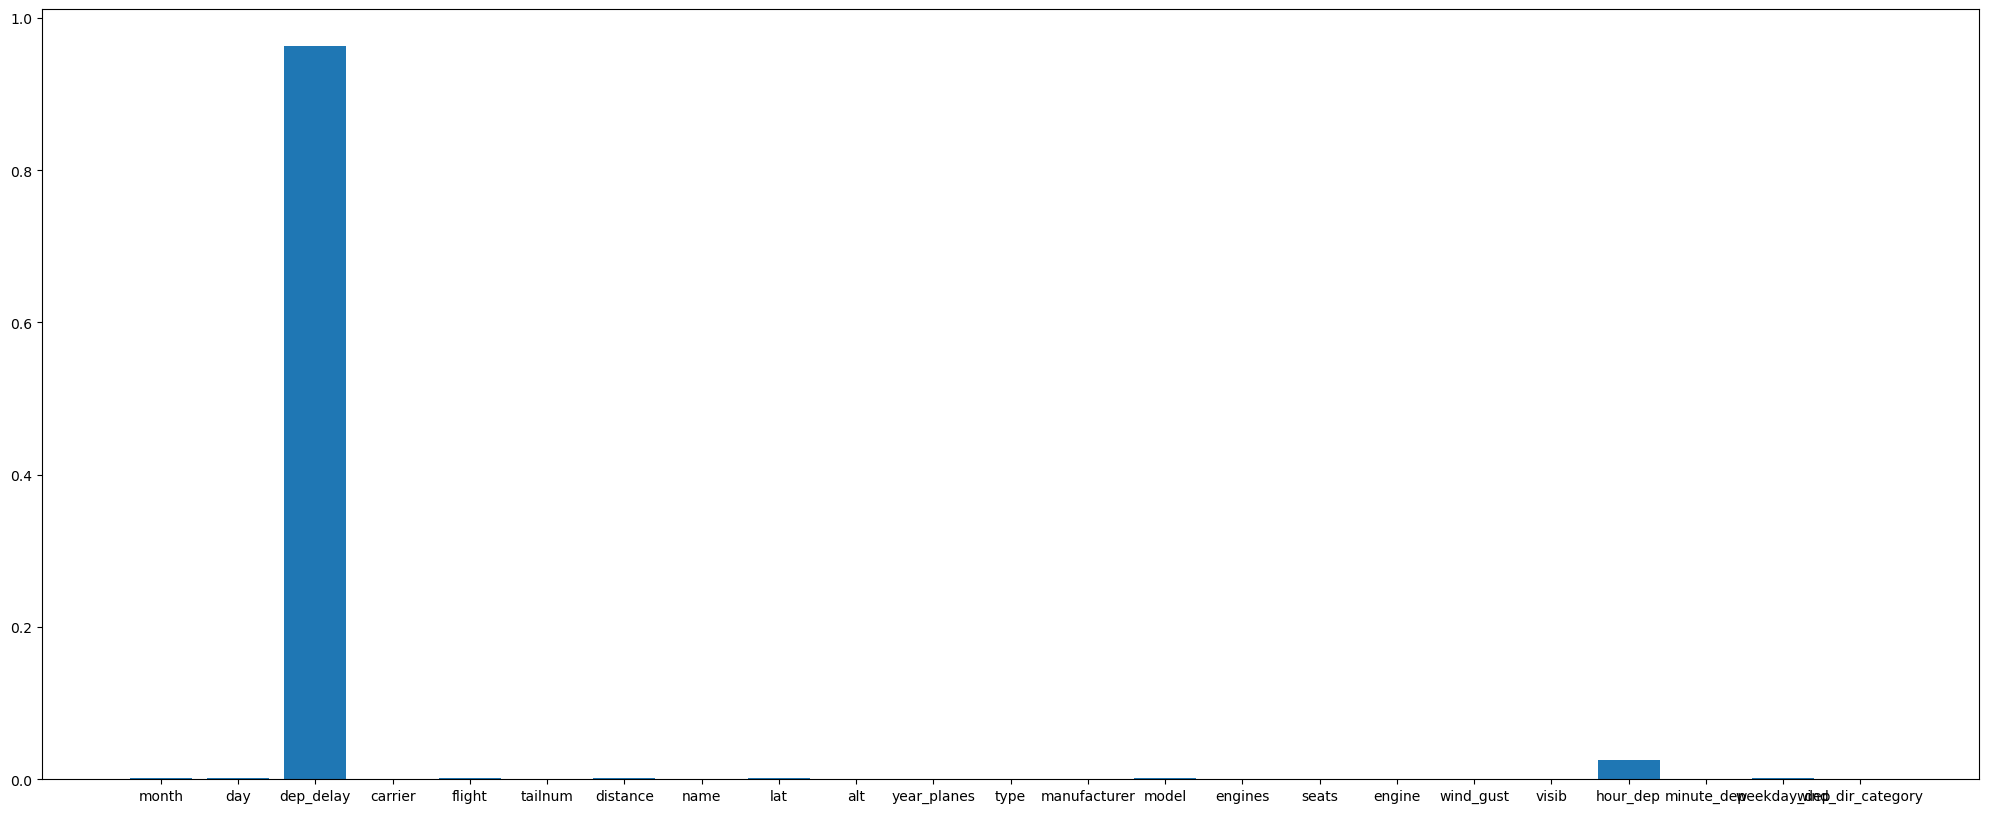

In [117]:
plt.figure(figsize=(25,10))
ax = plt.bar(list(df_feature.columns),rf_final_model.feature_importances_)

### 4-5. Additional Analysis

In [118]:
df_feature_added = df_filtered.drop(["arr_delay", "dep_delay"], axis=1).copy()

In [119]:
X_train_added, X_test_added, y_train_added, y_test_added = train_test_split(df_feature_added, df_label, test_size = 0.3, random_state=random_state)

In [120]:
hyper_params_xgb = {"colsample_bytree":[1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 8, 10],
                    'n_estimators': [10, 15, 20, 25]}

xgb_regr = XGBRegressor(n_estimators = 500, max_depth = 9,min_child_weight= 1.2,colsample_bytree = 1.0)
grid_cv_xgb = GridSearchCV(xgb_regr, param_grid = hyper_params_xgb, cv = 3, n_jobs = -1)
grid_cv_xgb.fit(X_train_added, y_train_added)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=9, max_leaves=None,
                                    min_child_weight=1.2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'max_depth': [4, 8, 10],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [10, 15, 20, 25]})

In [121]:
xgb_added_model = XGBRegressor(**grid_cv.best_params_)
xgb_added_model.fit(X_train_added, y_train_added)

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:36:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_features=0.9,
             max_leaves=None, min_child_weight=None, min_samples_leaf=4,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=25, n_jobs=None, ...)

In [122]:
y_prd=grid_cv_xgb.predict(X_test_added)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 43.889269


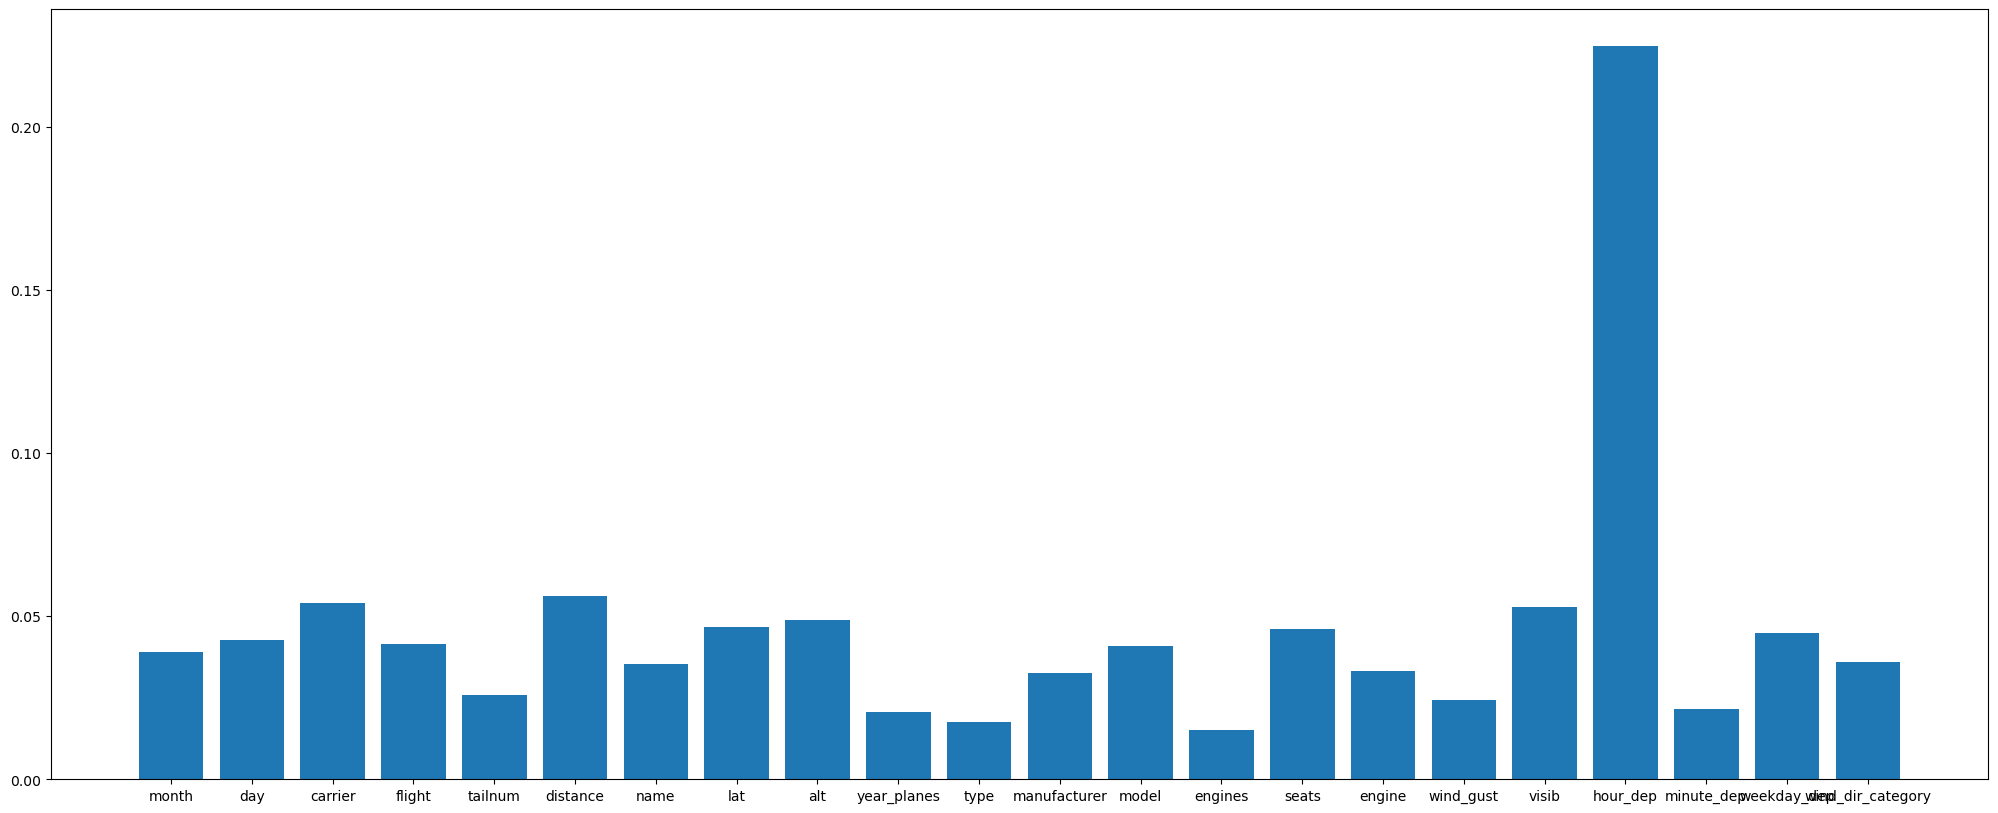

In [123]:
plt.figure(figsize=(25,10))
ax = plt.bar(list(df_feature_added.columns),xgb_added_model.feature_importances_)